In [50]:
from netCDF4 import Dataset
import numpy as np
import datetime as dt
import os

import matplotlib.pyplot as plt

In [64]:
def get_data(year, month, day, variable_name, is_mask=False) -> np.ndarray:

    date = dt.date(year,month,day).strftime('%Y%m%d')
    
    if year < 2016 : 
        D = Dataset(f'/Volumes/T7/AVHRR_OI_SST/v2.1/{year}/oisst-avhrr-v02r01.{date}.nc', 'r', format='NETCDF4')
        variables = ['anom', 'err', 'ice', 'lat', 'lon', 'sst', 'time', 'zlev']

    else :
        if os.path.exists(f'/Volumes/T7/AVHRR_OI_SST/v2.1/{year}/{date}120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc'):
            D = Dataset(f'/Volumes/T7/AVHRR_OI_SST/v2.1/{year}/{date}120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc', 'r', format='NETCDF4')
        else :
            D = Dataset(f'/Volumes/T7/AVHRR_OI_SST/v2.1/{year}/{date}120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.1-fv02.1.nc', 'r', format='NETCDF4')
        
        if variable_name == 'err' : variable_name = 'analysis_error'
        elif variable_name == 'sst' : variable_name = 'analysed_sst'
        elif variable_name == 'ice' : variable_name = 'sea_ice_fraction'
        
        variables = ['lat', 'lon', 'time', 'lat_bnds', 'lon_bnds', 'analysed_sst', 'analysis_error', 'mask', 'sea_ice_fraction']
    
    var = D[variable_name]
    masked_array = var[:]
    if year < 2016 : 
        data = masked_array.data[0][0]
        mask = masked_array.mask[0][0]
    else : 
        data = masked_array.data[0]
        mask = masked_array.mask[0]

    D.close()
    
    if is_mask == False : return data
    else : return mask

In [69]:
err = get_data(2015,12,1,'err',is_mask=True)

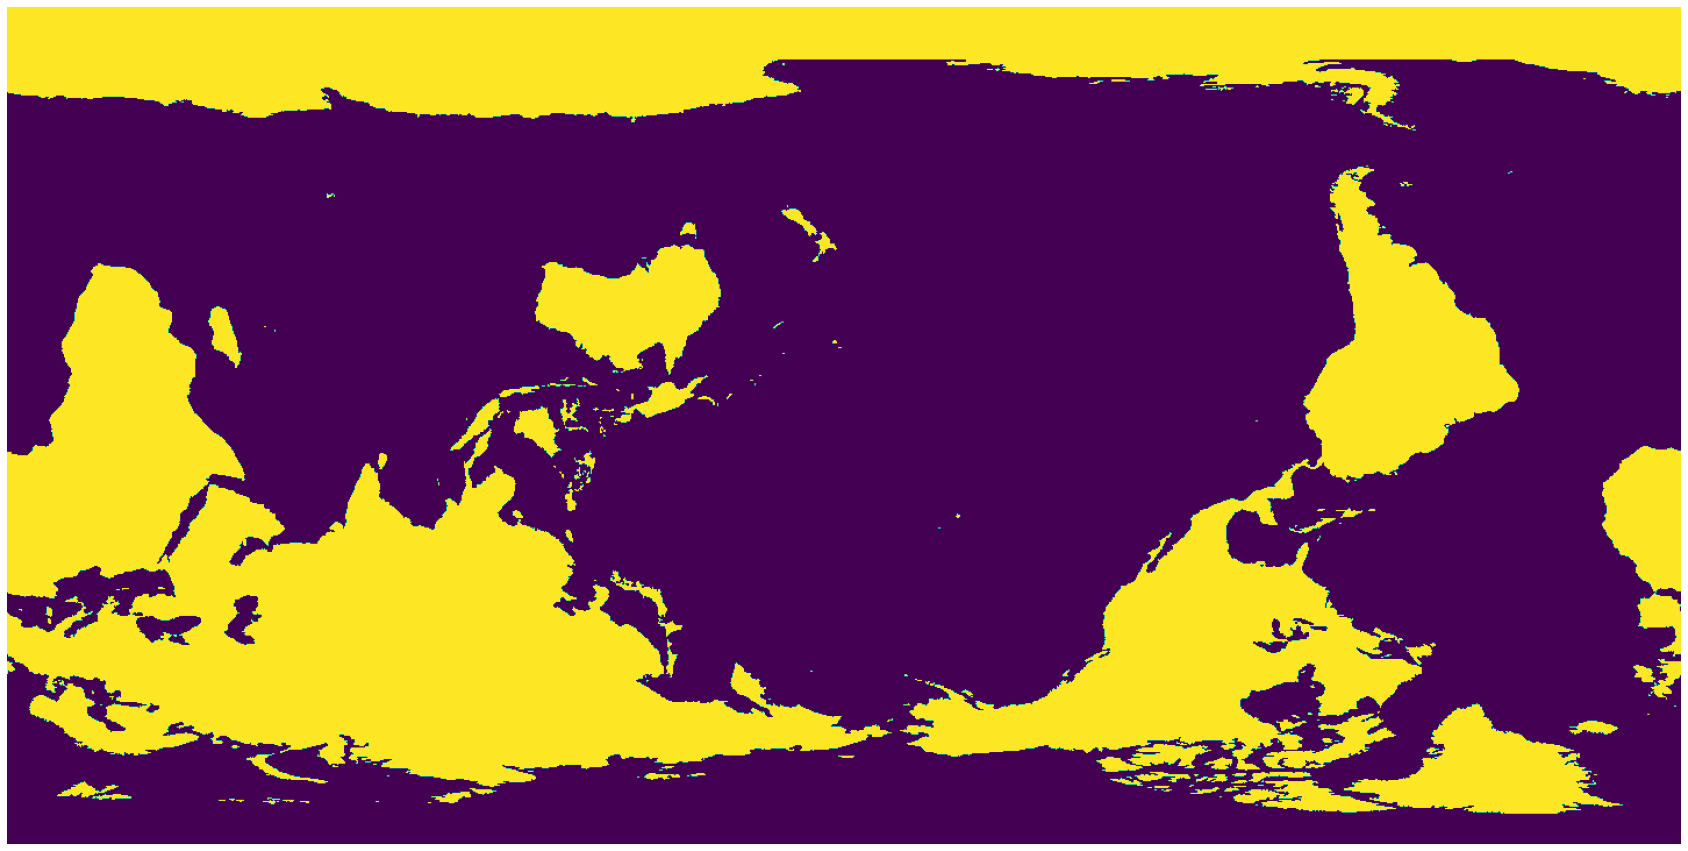

In [70]:
fig = plt.figure(figsize=(30,20))
plt.imshow(err)
plt.axis('off')
plt.show()

In [28]:
arr

array([[[[-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
          -9.9900000e+02, -9.9900000e+02, -9.9900000e+02],
         [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
          -9.9900000e+02, -9.9900000e+02, -9.9900000e+02],
         [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
          -9.9900000e+02, -9.9900000e+02, -9.9900000e+02],
         ...,
         [ 2.9999998e-01,  2.9999998e-01,  2.9999998e-01, ...,
           2.9999998e-01,  2.9999998e-01,  2.9999998e-01],
         [ 2.9999998e-01,  2.9999998e-01,  2.9999998e-01, ...,
           2.9999998e-01,  2.9999998e-01,  2.9999998e-01],
         [ 2.9999998e-01,  2.9999998e-01,  2.9999998e-01, ...,
           2.9999998e-01,  2.9999998e-01,  2.9999998e-01]]]],
      dtype=float32)